In [6]:
library("tidymodels")
library("tidyverse")
library("stringr")

In [7]:
seoul_bike_df<-read.csv("cleaned_seoul_bike_sharing.csv")

In [8]:
# remove DATE and FUNCTIONING_DAY collumn
seoul_bike_df<- seoul_bike_df %>% select(-DATE,-FUNCTIONING_DAY)

We won't be using the `DATE` and `FUNCTIONING_DAY` column, because `DATE`' is basically acts like an data entry index,while `FUNCTIONING_DAY` only has one distinct value remaining (`YES`) after missing value processing

### Convert HOUR, HOLIDAY, and SEASONS  columns into indicator columns.


In [9]:
# convert hour collumn into indicator collumn
hour_indicator_df<-seoul_bike_df %>%
mutate(dummy= 1) %>%
spread(key=HOUR,
        value= dummy,
         fill= 0)

#convert HOLIDAY collumn into indicator collumn
holiday_indicator_df<-hour_indicator_df %>%
mutate(dummy=1)%>%
spread(key=HOLIDAY,
        value= dummy,
         fill= 0)

#convert SEASONS collumn into indicator collumn
converted_bike_sharing_df<-holiday_indicator_df %>%
mutate(dummy= 1) %>%
spread(key=SEASONS,
        value= dummy,
         fill= 0)

#standardize the collumn names by converting all collumn names to uppercase
colnames(converted_bike_sharing_df)<- toupper(colnames(converted_bike_sharing_df))

#print the structure
str(converted_bike_sharing_df)

'data.frame':	8465 obs. of  39 variables:
 $ RENTED_BIKE_COUNT    : int  254 204 173 107 78 100 181 460 930 490 ...
 $ TEMPERATURE          : num  -5.2 -5.5 -6 -6.2 -6 -6.4 -6.6 -7.4 -7.6 -6.5 ...
 $ HUMIDITY             : int  37 38 39 40 36 37 35 38 37 27 ...
 $ WIND_SPEED           : num  2.2 0.8 1 0.9 2.3 1.5 1.3 0.9 1.1 0.5 ...
 $ VISIBILITY           : int  2000 2000 2000 2000 2000 2000 2000 2000 2000 1928 ...
 $ DEW_POINT_TEMPERATURE: num  -17.6 -17.6 -17.7 -17.6 -18.6 -18.7 -19.5 -19.3 -19.8 -22.4 ...
 $ SOLAR_RADIATION      : num  0 0 0 0 0 0 0 0 0.01 0.23 ...
 $ RAINFALL             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SNOWFALL             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 0                    : num  1 0 0 0 0 0 0 0 0 0 ...
 $ 1                    : num  0 1 0 0 0 0 0 0 0 0 ...
 $ 2                    : num  0 0 1 0 0 0 0 0 0 0 ...
 $ 3                    : num  0 0 0 1 0 0 0 0 0 0 ...
 $ 4                    : num  0 0 0 0 1 0 0 0 0 0 ...
 $ 5                    : num  0 0 0 0 

### Normalize data

In [10]:
# min max normalization Function
min_max<-function(x){
    return((x-min(x))/(max(x)-min(x)))
    }
normalized_bike_sharing<-converted_bike_sharing_df %>% mutate(TEMPERATURE=min_max(TEMPERATURE),
                          HUMIDITY=min_max(HUMIDITY),
                          WIND_SPEED=min_max(WIND_SPEED),
                          VISIBILITY=min_max(VISIBILITY),
                          DEW_POINT_TEMPERATURE=min_max(DEW_POINT_TEMPERATURE),
                          SOLAR_RADIATION=min_max(SOLAR_RADIATION),
                          RAINFALL=min_max(RAINFALL),
                          SNOWFALL=min_max(SNOWFALL)) 

summary(normalized_bike_sharing)

 RENTED_BIKE_COUNT  TEMPERATURE        HUMIDITY        WIND_SPEED    
 Min.   :   2.0    Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 214.0    1st Qu.:0.3636   1st Qu.:0.4286   1st Qu.:0.1216  
 Median : 542.0    Median :0.5472   Median :0.5816   Median :0.2027  
 Mean   : 729.2    Mean   :0.5345   Mean   :0.5933   Mean   :0.2332  
 3rd Qu.:1084.0    3rd Qu.:0.7080   3rd Qu.:0.7551   3rd Qu.:0.3108  
 Max.   :3556.0    Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   VISIBILITY     DEW_POINT_TEMPERATURE SOLAR_RADIATION       RAINFALL       
 Min.   :0.0000   Min.   :0.0000        Min.   :0.000000   Min.   :0.000000  
 1st Qu.:0.4602   1st Qu.:0.4412        1st Qu.:0.000000   1st Qu.:0.000000  
 Median :0.8429   Median :0.6107        Median :0.002841   Median :0.000000  
 Mean   :0.7131   Mean   :0.5977        Mean   :0.161326   Mean   :0.004261  
 3rd Qu.:1.0000   3rd Qu.:0.7924        3rd Qu.:0.264205   3rd Qu.:0.000000  
 Max.   :1.0000   Max.   :1.0000        Ma

### Split the dataset into training and testing

In [32]:
set.seed(1234)
df_split <- initial_split(normalized_bike_sharing,prop=4/5)
train_data<- training(df_split)
test_data<- testing(df_split)

# define the linear regression model specification
lm_engine<- linear_reg() %>%
set_engine(engine="lm")




### Build the linear regression model


In [38]:
#Linear regression model with weather variables only
lm_model_weather<- lm_engine %>%
    fit(RENTED_BIKE_COUNT~TEMPERATURE + HUMIDITY + WIND_SPEED + VISIBILITY + 
        DEW_POINT_TEMPERATURE + SOLAR_RADIATION + RAINFALL + SNOWFALL,data=train_data)

#linear regression model with all variables
lm_model_all<-lm_engine %>%
fit(RENTED_BIKE_COUNT~.,data=train_data)
summary(lm_model_all$fit)


Call:
stats::lm(formula = RENTED_BIKE_COUNT ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1396.06  -217.63    -7.03   201.50  1798.67 

Coefficients: (3 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             315.83      50.63   6.238 4.69e-10 ***
TEMPERATURE             789.85     204.31   3.866 0.000112 ***
HUMIDITY               -887.07      95.92  -9.248  < 2e-16 ***
WIND_SPEED               13.72      38.75   0.354 0.723277    
VISIBILITY               18.20      19.56   0.930 0.352196    
DEW_POINT_TEMPERATURE   602.49     213.16   2.827 0.004719 ** 
SOLAR_RADIATION         271.86      39.98   6.800 1.14e-11 ***
RAINFALL              -2095.13     142.03 -14.752  < 2e-16 ***
SNOWFALL                230.03      99.82   2.304 0.021226 *  
`0`                    -120.36      32.11  -3.748 0.000180 ***
`1`                    -224.29      31.88  -7.035 2.19e-12 ***
`2`                  

In [34]:
#
weather_test_result<-lm_model_weather %>%
predict(new_data=test_data) %>%
mutate(truth= test_data$RENTED_BIKE_COUNT)
head(weather_test_result)

all_test_result<-lm_model_all %>%
predict(new_data=test_data) %>%
mutate(truth= test_data$RENTED_BIKE_COUNT)
head(all_test_result)

.pred,truth
<dbl>,<int>
317.21735,100
321.47531,181
591.78405,360
17.92040,405
-67.70542,328
519.48746,479


Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from a rank-deficient fit may be misleading"


.pred,truth
<dbl>,<int>
-179.55574,100
-17.38191,181
220.94815,360
466.76903,405
-78.68774,328
288.29215,479


### Evaluate the model

In [35]:
#Calculate the R-squared from linear model with weather variables only
rsq(weather_test_result,truth=truth,estimate=.pred)

#Calculate the R-squared from linear model with all variables
rsq(all_test_result,truth=truth,estimate=.pred)

#calculate the Root Mean square from linear model with weather variables only
rmse(test_result,truth=truth,estimate=.pred)

#calculate the Root Mean square from linear model with all variables 
rmse(all_test_result,truth=truth,estimate=.pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.438825


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.6697274


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,474.6247


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,363.737


From the tables above, we ca see that the test results `lm_model_all` peform much beter.

Since `lm_model_all` has many predictor variables, let's check which predictor variables have larger coefficients.

In [55]:
#retrieve the coefficient from lm_model_all
coeficient<-abs(lm_model_all$fit$coefficients)

#retrieve each collumn names
collumn<-colnames(converted_bike_sharing_df)

#combine the coefficient and collumn name into a dataframe
coefficient_df<-data.frame(variables=collumn,coefficients=coeficient)

#sort the dataframe in descending order using coefficient collumn
sorted_coefficient_df<-coefficient_df[order(-coefficient_df$coefficients),] 

#turned the missing value into 0
sorted_coefficient_df[is.na(sorted_coefficient_df)]<- 0
head(sorted_coefficient_df)

,variables,coefficients
,<chr>,<dbl>
RAINFALL,RAINFALL,2095.1299
HUMIDITY,HUMIDITY,887.0713
TEMPERATURE,TEMPERATURE,789.8480
`18`,18,689.2575
DEW_POINT_TEMPERATURE,DEW_POINT_TEMPERATURE,602.4932
`4`,4,483.1542


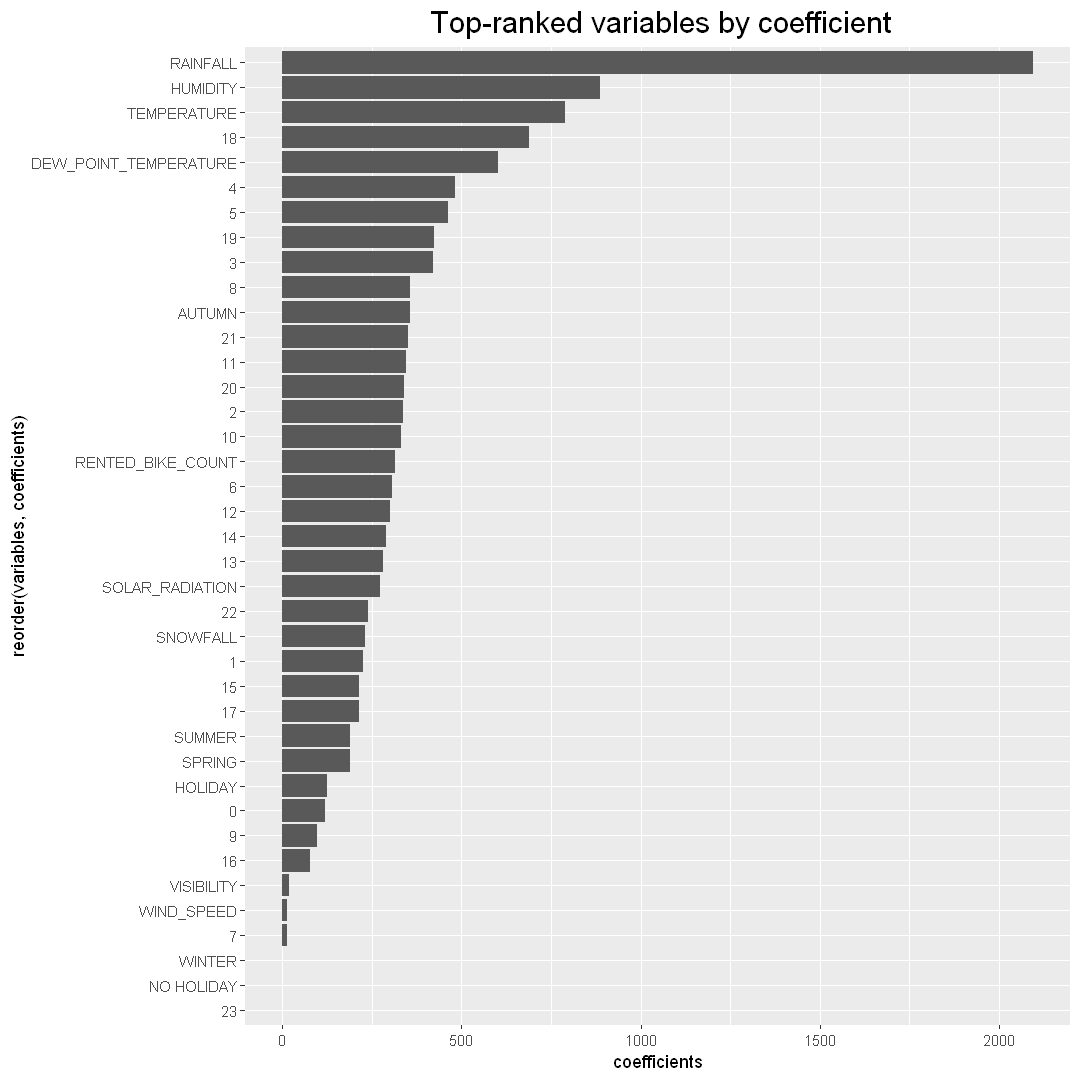

In [65]:
#visualize the dataframe
options(repr.plot.width=9, repr.plot.height=9)
ggplot(sorted_coefficient_df,aes(x=coefficients,y=reorder(variables,coefficients)))+
        geom_bar(stat="identity")+
        ggtitle("Top-ranked variables by coefficient")+
        theme(plot.title = element_text(size =18,hjust=0.51))

these `Top-ranked variables by coefficient` plot will be very usefull for model refinement in the next step